In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')


from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



In [2]:
os.chdir('..')

In [3]:
data = pd.read_parquet(os.path.join(os.getcwd(), 'data','modelData', 'modelData.parquet'))

In [4]:
data = data.query("MASK == 2 & BIN == 32")\
           .reset_index(drop = True)

In [5]:
y = data[["SEVERE"]]
X = data.drop(columns = ["MASK", "BIN", "SEVERE", "ID"])
cols = X.columns

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns  = cols)

In [7]:
#0.3 and 3 C values where used to make the figures.
logreg_strong = LogisticRegression(penalty = "l1",
                            C = 0.3, # Smaller values specify stronger regularization.
                            solver = "saga",
                            max_iter = 10000,
                            n_jobs = 1)

#0.3 and 3 C values where used to make the figures.
logreg_weak = LogisticRegression(penalty = "l1",
                            C = 3, # Smaller values specify stronger regularization.
                            solver = "saga",
                            max_iter = 10000,
                            n_jobs = 1)

sfs_strong  = SFS(logreg_strong, 
                  k_features=93, 
                  forward=True, 
                  floating=False, 
                  verbose=0,
                  scoring='roc_auc',
                  cv=4,
                  n_jobs=-1)

sfs_weak  =   SFS(logreg_weak, 
                  k_features=93, 
                  forward=True, 
                  floating=False, 
                  verbose=0,
                  scoring='roc_auc',
                  cv=4,
                  n_jobs=-1)



In [8]:
sfs_strong = sfs_strong.fit(X, y.values.squeeze())

In [9]:
sfs_weak = sfs_weak.fit(X, y.values.squeeze())

In [10]:
result_strong = sfs_strong.get_metric_dict(confidence_interval=0.95)
aux_strong=pd.DataFrame.from_dict(result_strong).T

In [11]:
result_weak = sfs_weak.get_metric_dict(confidence_interval=0.95)
aux_weak=pd.DataFrame.from_dict(result_weak).T

In [12]:
aux_weak_f = aux_weak["cv_scores"].explode()\
                                  .reset_index()\
                                  .rename(columns = {"index": "feature", "cv_scores" : "AUC"})
aux_weak_f["label"] = "Weak regularization"

In [13]:
aux_strong_f = aux_strong["cv_scores"].explode()\
                                      .reset_index()\
                                      .rename(columns = {"index": "feature", "cv_scores" : "AUC"})
aux_strong_f["label"] = "Strong regularization"

In [14]:
data = pd.concat([aux_strong_f,aux_weak_f])

In [15]:
data["AUC"] = data["AUC"].astype(float)

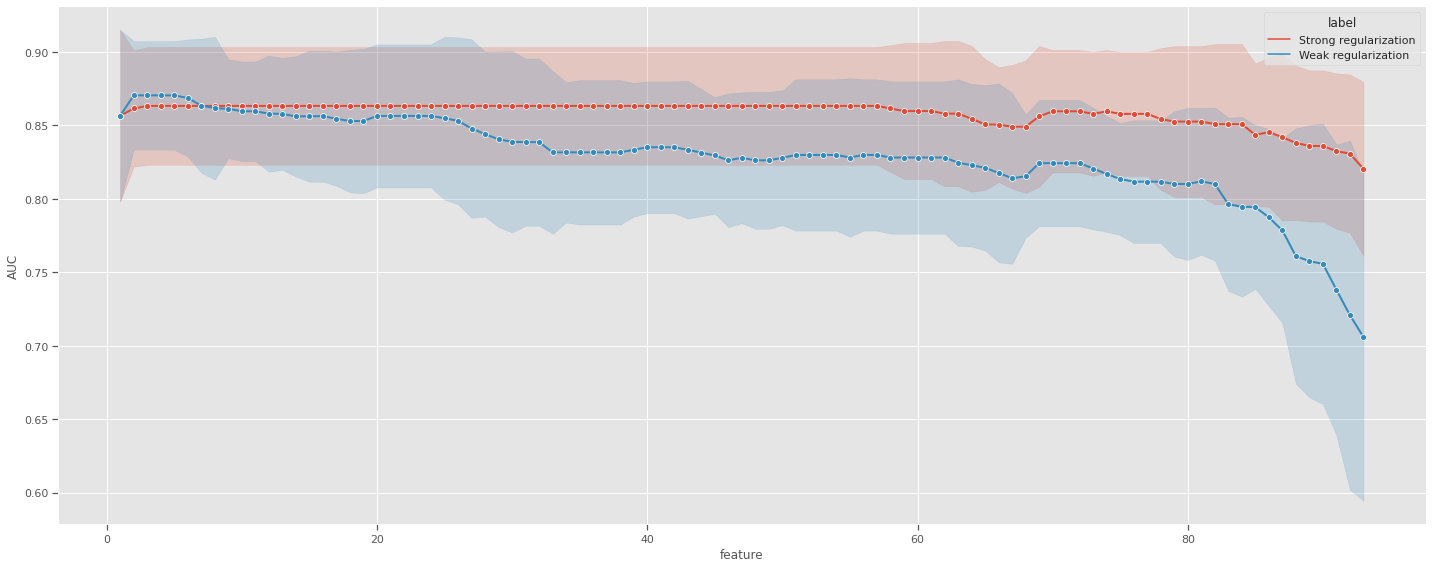

In [16]:
fig = plt.figure(figsize = (20,8))
sns.lineplot(data=data, x="feature", y="AUC", hue = "label", ci = "sd", marker="o", dashes=True, lw=2)
plt.tight_layout()
plt.savefig(os.path.join("figures", "model", "regularizationEffect.png"), format = "png")
plt.show()